# **Unsupervised Learning Project**
## **Introduction to Machine Learning**

#### Ali Mojahed
#### 9812762554

# Download and Unzip Dataset

In [ ]:
!wget -O ORL.zip https://www.dropbox.com/s/hgqggui5gtwqrr3/ORL.zip?dl=0
!unzip ORL.zip -d /content/ORL

# Open Images

In [ ]:
from PIL import Image, ImageOps
import glob
import numpy as np
#import all photos
image_list = list()
image_file_name_list = list()
for image_file in glob.glob("/content/ORL/*.jpg"):
  image = Image.open(image_file)
  image = ImageOps.grayscale(image)
  image_file = image_file.replace("/content/ORL/", "").replace(".jpg", "")
  image_arr = np.array(image)
  image_list.append(image_arr)
  image_file_name_list.append(image_file)

image_list = np.array(image_list)

number_of_people = 41

# Rand-Index Implementation

In [ ]:
def rand_index(clustered_data, data_label):
  tp, tn, fp, fn = 0, 0, 0, 0

  for i in range(len(clustered_data)):
    if clustered_data[i] == -1:
      continue
    for j in range(i+1, len(clustered_data)):
      if clustered_data[j] == -1:
        continue
      if clustered_data[i] == clustered_data[j]:
        if data_label[i].split("_")[1] == data_label[j].split("_")[1]:
          tp += 1
        else:
          fp += 1
      else:
        if data_label[i].split("_")[1] == data_label[j].split("_")[1]:
          fn += 1
        else:
          tn += 1

    rand_index = (tp + tn) / (tp + fp + fn + tn)

    return rand_index * 100

# Histogram Utility

In [ ]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 6]
def draw_histogram(data, title):
  bins = np.arange(-5, 50, 1) # fixed bin size

  plt.xlim([min(data)-5, max(data)+5])

  plt.hist(data, bins=bins, alpha=0.5)
  plt.xticks(np.arange(-1, max(data)+5, 2))
  plt.title(title)
  plt.xlabel('clusters')
  plt.ylabel('count')

  plt.show()

# KMeans Algorithm

In [ ]:
from sklearn.cluster import KMeans
nsamples, nx, ny = image_list.shape
d2_images = image_list.reshape((nsamples,nx*ny))
kmeans = KMeans(n_clusters=number_of_people).fit(d2_images)
kmeans_ri = rand_index(kmeans.labels_, image_file_name_list)
kmeans_ri

97.31051344743277

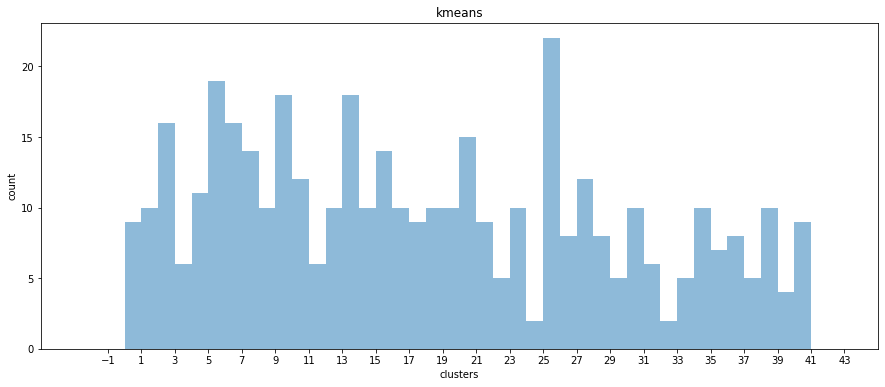

In [ ]:
draw_histogram(kmeans.labels_, "kmeans")

# DBSCAN Algorithm

In [ ]:
from sklearn.cluster import DBSCAN
nsamples, nx, ny = image_list.shape
d2_images = image_list.reshape((nsamples,nx*ny))
dbscan = DBSCAN(eps=2300, min_samples=2).fit(d2_images)
dbscan_ri = rand_index(dbscan.labels_, image_file_name_list)
dbscan_ri

97.20670391061452

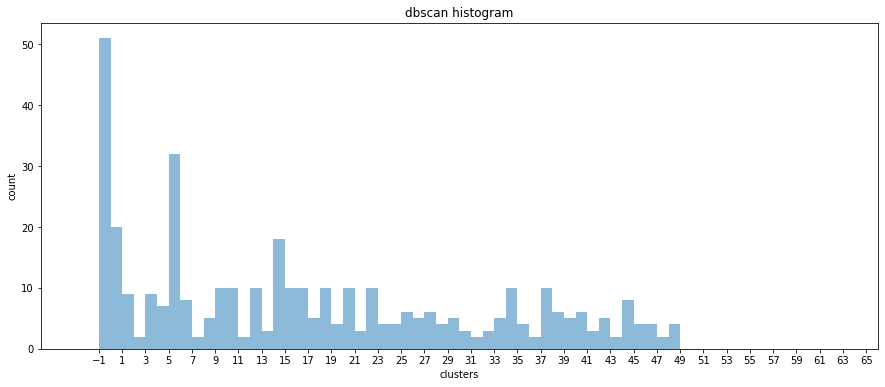

In [ ]:
draw_histogram(dbscan.labels_, "dbscan histogram")

# Agglomerative Algorithm

## Average-Link

In [ ]:
from sklearn.cluster import AgglomerativeClustering
nsamples, nx, ny = image_list.shape
d2_images = image_list.reshape((nsamples,nx*ny))
average_link = AgglomerativeClustering(n_clusters=number_of_people, linkage='average').fit(d2_images)
average_link_ri = rand_index(average_link.labels_, image_file_name_list)
average_link_ri

90.4645476772616

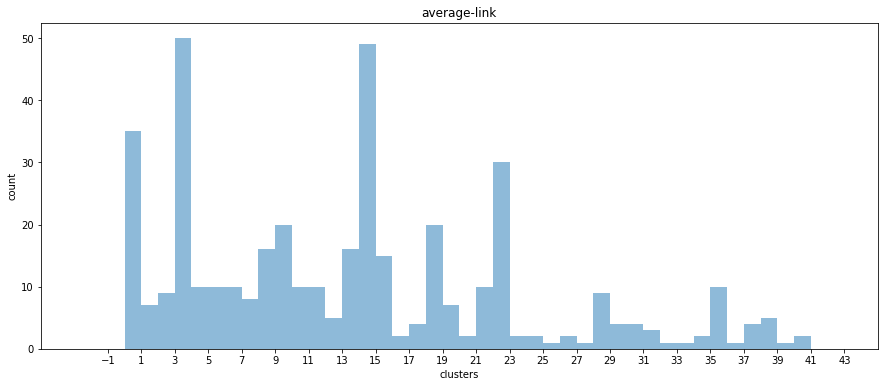

In [ ]:
draw_histogram(average_link.labels_, "average-link")

## Single-Link

In [ ]:
from sklearn.cluster import AgglomerativeClustering
nsamples, nx, ny = image_list.shape
d2_images = image_list.reshape((nsamples,nx*ny))
single_link = AgglomerativeClustering(n_clusters=number_of_people, linkage='single').fit(d2_images)
single_link_ri = rand_index(single_link.labels_, image_file_name_list)
single_link_ri

41.075794621026894

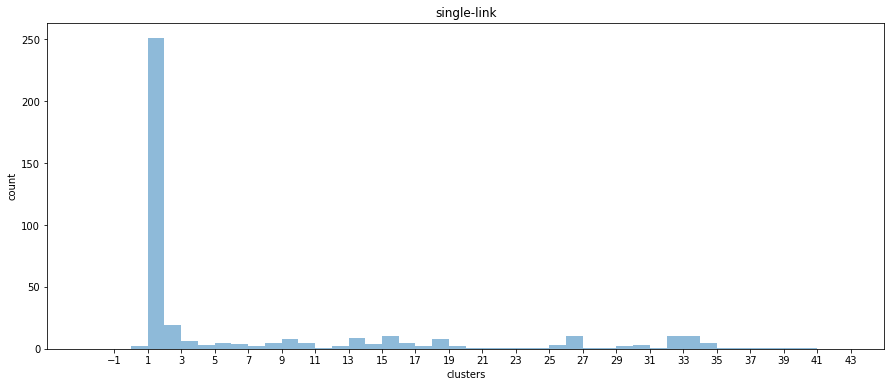

In [ ]:
draw_histogram(single_link.labels_, "single-link")

## Complete-Link

In [ ]:
from sklearn.cluster import AgglomerativeClustering
nsamples, nx, ny = image_list.shape
d2_images = image_list.reshape((nsamples,nx*ny))
complete_link = AgglomerativeClustering(n_clusters=number_of_people, linkage='complete').fit(d2_images)
complete_link_ri = rand_index(complete_link.labels_, image_file_name_list)
complete_link_ri

97.55501222493888

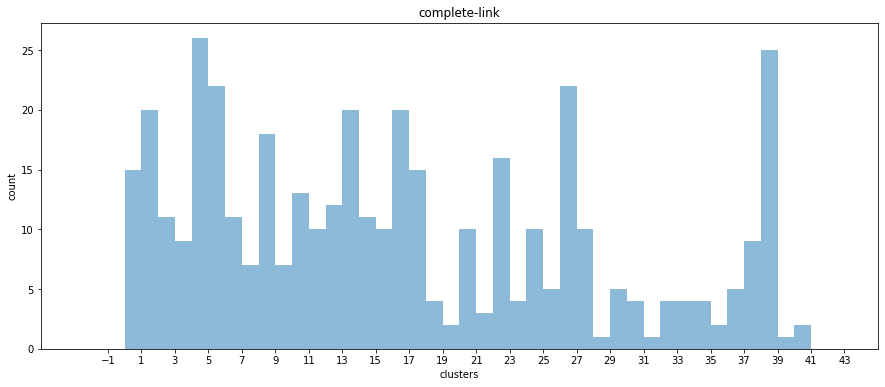

In [ ]:
draw_histogram(complete_link.labels_, "complete-link")

# Iterative Fixed-Cluster DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN
import time

class IterativeFixedClusterDBSCAN():
 def __init__(
        self,
        n_clusters=5,
        eps_growth_step = 0.05,
        eps_max_growth = 0.7,
        eps_min_growth = 0.2,
        min_sample_growth_step=1,
        min_sample_min_growth=2,
        max_sample_max_growth=10,
        time_limit = 2 * 60,
        metric="euclidean",
        metric_params=None,
        algorithm="auto",
        leaf_size=30,
        p=None,
        n_jobs=None):

  self.dbscan = DBSCAN(eps=eps_min_growth, min_samples=min_sample_min_growth, metric=metric, metric_params=metric_params, algorithm=algorithm, leaf_size=leaf_size, p=p, n_jobs=n_jobs)

  self.n_clusters = n_clusters
  self.time_limit = time_limit * 1.0

  self.eps_growth_step = eps_growth_step
  self.eps_max_growth = eps_max_growth
  self.eps_min_growth = eps_min_growth

  self.min_sample_grwoth_step = min_sample_growth_step
  self.min_sample_min_growth = min_sample_min_growth
  self.max_sample_max_growth = max_sample_max_growth


 def fit(self, X, y=None, sample_weight=None):
  number_of_clusters = 0
  execute_time = 0
  start_time = time.time()
  base_eps = self.dbscan.eps
  base_min_sample = self.dbscan.min_samples
  # self.lables_ = [-1]
  for eps in range(self.eps_min_growth, self.eps_max_growth, self.eps_growth_step):
    for min_sample in range(self.min_sample_min_growth, self.max_sample_max_growth, self.min_sample_grwoth_step):
      self.dbscan.eps = eps
      self.dbscan.min_samples = min_sample

      labels = self.dbscan.fit_predict(X, y, sample_weight)
      # print(labels)
      execute_time = time.time() - start_time
      # print(max(labels))
      if max(labels)+1 == self.n_clusters:
        # self.min_samples = min_sample
        # self.eps = eps
        return self.dbscan
      if execute_time > self.time_limit:
        self.dbscan.labels_ = [-1 for i in X]
        return self.dbscan

  return self.dbscan


In [ ]:
nsamples, nx, ny = image_list.shape
d2_images = image_list.reshape((nsamples,nx*ny))
ifc_dbscan = IterativeFixedClusterDBSCAN(n_clusters=number_of_people, eps_growth_step=5,
                                         eps_max_growth=3000, eps_min_growth=2200,
                                         min_sample_growth_step=1, min_sample_min_growth=3,
                                         max_sample_max_growth=11).fit(d2_images)
ifc_dbscan_ri = rand_index(ifc_dbscan.labels_, image_file_name_list)
ifc_dbscan_ri

96.95121951219512

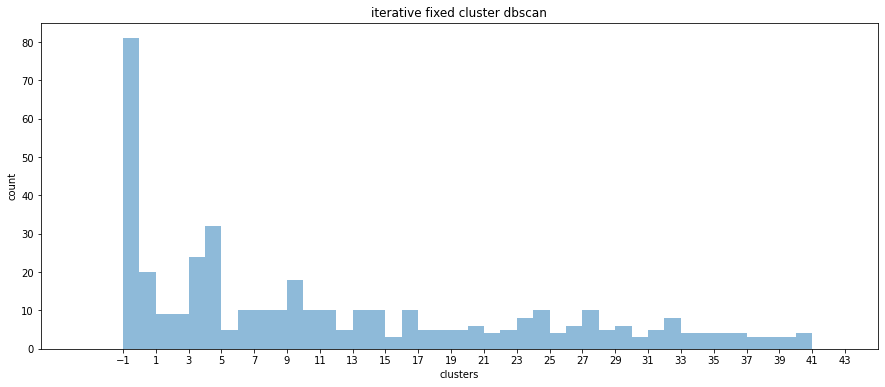

In [ ]:
draw_histogram(ifc_dbscan.labels_, "iterative fixed cluster dbscan")

# Epsilon-Based KMeans

In [ ]:
class EpsilonBasedKMeans:
    def __init__(self, k=2, tol=0.001, max_iter=5, eps=1):
        self.k = k
        self.tol = tol
        self.max_iter = max_iter
        self.eps = eps

    def _get_neighbors(self, centroid):
        """ Return a list of indexes of neighboring samples
        A sample_2 is considered a neighbor of sample_1 if the distance between
        them is smaller than epsilon """
        neighbors = []
        idxs = np.arange(len(self.X))
        for i, _sample in enumerate(self.X):
            distance = np.linalg.norm(centroid-_sample)
            # print(distance)
            if distance < self.eps:
                neighbors.append(i)
        return np.array(neighbors)


    def fit(self,data):

        self.centroids = {}
        data = data / 255
        self.X = data
        origin_centroid_label = []
        # for centroid in range(k):
        #   centroid = np.random.uniform(centroid_min, centroid_max, n_dims)
        #   centroids.append(centroid)

        for i in range(self.k):
            ci = int(np.random.uniform(0, len(data), 1))
            self.centroids[i] = data[ci]
            origin_centroid_label.append(ci)

        for i in range(self.max_iter):
            self.classifications = {}

            for i in range(self.k):
                self.classifications[i] = []
            self.label = []
            neighbors = []
            for centroid in self.centroids:
              neighbors.append(self._get_neighbors(centroid))
            for index, featureset in enumerate(data):
                distances = []
                find_centroid = False
                for ci, centroid in enumerate(self.centroids):
                  if index in neighbors[ci]:
                    find_centroid = True
                    distances.append(np.linalg.norm(featureset-self.centroids[centroid]))
                  else:
                    distances.append(10e15)
                if index in origin_centroid_label:
                  classification = origin_centroid_label.index(index)
                  self.classifications[classification].append(featureset)
                elif find_centroid:
                  classification = distances.index(min(distances))
                  self.classifications[classification].append(featureset)
                else:
                  print("hello")
                  classification = -1

                self.label.append(classification)

            prev_centroids = dict(self.centroids)

            for classification in self.classifications:
                self.centroids[classification] = np.average(self.classifications[classification],axis=0)

            optimized = True

            for c in self.centroids:
                original_centroid = prev_centroids[c]
                current_centroid = self.centroids[c]
                if np.sum((current_centroid-original_centroid)/original_centroid*100.0) > self.tol:
                    # print(np.sum((current_centroid-original_centroid)/original_centroid*100.0))
                    optimized = False

            if optimized:
                break

    def predict(self,data):
        distances = [np.linalg.norm(data-self.centroids[centroid]) for centroid in self.centroids]
        classification = distances.index(min(distances))
        return classification

In [ ]:
model = EpsilonBasedKMeans(k=41, eps=2300)
nsamples, nx, ny = image_list.shape
d2_images = image_list.reshape((nsamples,nx*ny))
model.fit(d2_images)
ep_kmeans_ri = rand_index(model.label, image_file_name_list)
ep_kmeans_ri

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in true_divide


95.84352078239608

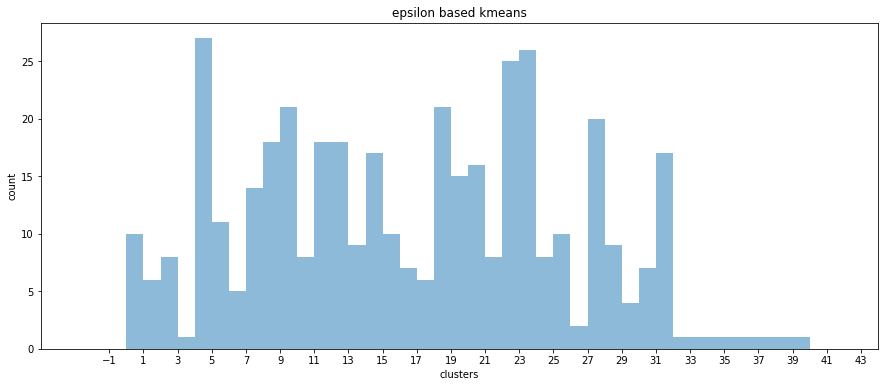

In [ ]:
draw_histogram(model.label, "epsilon based kmeans")

# Current Run RI Metrics

In [ ]:
algo = ["Kmeans", "DBSCAN", "Average-Link", "Single-Link", "Complete-Link", "IFC-DBSCAN", "Eps Kmeans"]
ri = [kmeans_ri, dbscan_ri, average_link_ri, single_link_ri, complete_link_ri, ifc_dbscan_ri, ep_kmeans_ri]

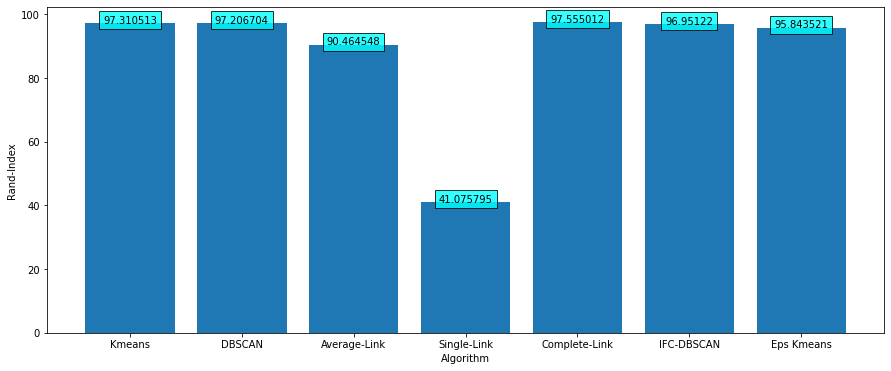

In [ ]:
def valuelabel(algo,ri):
    for i in range(len(algo)):
        plt.text(i,round(ri[i], 4),round(ri[i], 6), ha = 'center',
                 bbox = dict(facecolor = 'cyan', alpha =0.8))

# Plot bar chart
plt.bar(algo, ri)

# Call function
valuelabel(algo, ri)

# Define labels
plt.xlabel("Algorithm")
plt.ylabel("Rand-Index")

# Display plot
plt.show()

# References


*   https://github.com/eriklindernoren/ML-From-Scratch/blob/master/mlfromscratch/unsupervised_learning/dbscan.py
*   https://medium.com/@rishit.dagli/build-k-means-from-scratch-in-python-e46bf68aa875

*  https://anderfernandez.com/en/blog/kmeans-algorithm-python/

*  https://pythonguides.com/matplotlib-bar-chart-labels/
*  https://stackoverflow.com/questions/24809757/how-to-make-a-histogram-from-a-list-of-data
*  https://scikit-learn.org/stable/modules/classes.html#module-sklearn.cluster

